In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
from scipy.stats.stats import pearsonr   
import seaborn as sns
import pandas as pd
sns.set()

In [3]:
import model
import utilities as ut

In [80]:
def lhs(cons: float, x0: float) -> float:
    return (cons ** 2 / x0) ** 2

def rhs(cons: float, gt: float, gamma: float = 1, r: float = 0) -> float:
    return 1 / (1 + r) - cons / ((gt - cons) * gamma)

def bisection(x0: float, gt: float, gamma: float, r: float = 0, err: float = 1e-2) -> float:
    # Define the left and right hand sides of the equations
    diff = lambda a: rhs(a, gt, gamma, r) - lhs(a, x0)

    # Initial guess at the next options for
    x = [0, gt / 4, gt / 2]
    abs_lst = [abs(diff(i)) for i in x[:2]]

    while min(abs_lst) >= err:
        test = np.sign([diff(i) for i in x])

        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

def hh_feedback(x: float, x0: float, xmin: float = 0, xmax: float = 0.7, a: float = 10) -> float:
    return 0.5 * (np.tanh(a * (x - x0)) * (xmax - xmin) + xmax + xmin)

In [198]:
def step(t: float, x: np.ndarray, p: dict):
    # Starting variables
    z_, ks_, news_, cons_, labour_, bond_, feedback_, wage_, xi_, r_ = x

    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xi = p['etaZ'] * xi_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xi)
        
    # Income and Investment
    income = wage_ * labour_ + bond_ / (1 + p['inflation']) + r_*ks_
    #feedback = hh_feedback(news_, 0, p['xmin'], p['xmax'], p['theta'])
    
    
    
    # Capital Markets
    ks = (1 - p['depreciation']) * ks_ + income * (1 - feedback_)
    x0 = z * np.sqrt(2 * ks)

    # Household decision variables
    cons = bisection(x0, feedback_ * income, p['gamma'], r_)
    labour = (cons ** 2) / (4 * ks * (z ** 2))
    bond = (feedback_ * income - cons) * (1 + r_)
    
    # Savings decision
    # news =  p['c1']*news_ + p['c2']*np.tanh(cons/cons_ - 1) + p['c3']*np.tanh(ks/ks_ - 1)
    #v_news = -news_ + np.tanh(p['c1']*news_ + p['c2']*(cons/cons_ - 1) + p['c3']*(ks/ks_ - 1))
    
    fake_news = 0 #np.random.normal(0, p['sigmaZ'])
    news =  np.tanh(p['c1']*news_ + p['c2']*(cons/cons_ - 1) + p['c3']*(ks/ks_ - 1) + fake_news)
    feedback = 0.5*(news*(p['xmax']-p['xmin']) + p['xmax'] + p['xmin'])
        
    # Cost of production via mkt clearing and profit maximisation
    wage = 0.5 * cons / labour
    r = 2 * z * np.sqrt(labour/ks)
    
    return z, ks, news, cons, labour, bond, feedback, wage, xi, r

def simulate(start: np.ndarray, p: dict, t_end: float = 1e3):
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p)
    cols = ['technology', 'capital', 'news', 'consumption',
            'labour', 'bond', 'feedback', 'wage', 'xi', 'coc']
    return pd.DataFrame(x, columns=cols)

<ipython-input-198-a1e51717c75f>:34: RuntimeWarning: divide by zero encountered in double_scalars
  wage = 0.5 * cons / labour
<ipython-input-198-a1e51717c75f>:11: RuntimeWarning: invalid value encountered in double_scalars
  income = wage_ * labour_ + bond_ / (1 + p['inflation']) + r_*ks_
<ipython-input-198-a1e51717c75f>:30: RuntimeWarning: invalid value encountered in double_scalars
  news =  np.tanh(p['c1']*news_ + p['c2']*(cons/cons_ - 1) + p['c3']*(ks/ks_ - 1) + fake_news)


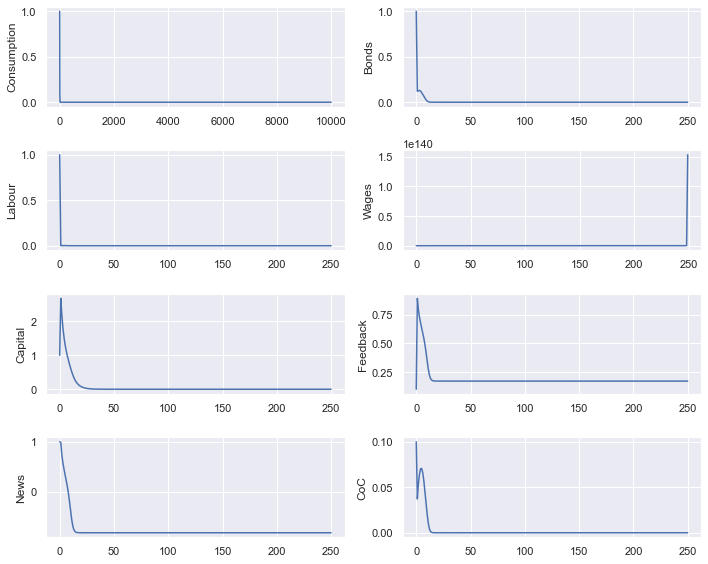

In [209]:
# SET PARAMETERS
alpha = 0.9
m = 1e0
params = dict(
    etaZ=0, sigmaZ=1.0, zbar=1,
    inflation=0.01, interest=0.01, 
    k0=0.0, xmin=0.1, xmax=0.9, theta=10,
    c1=1.1, c2=m*(1-alpha), c3=m*alpha,
    depreciation=0.2, gamma=1
)

# INITIAL VALUES
start = dict(
    z=1, k=1, news=1, 
    cons=1, labour=1, bonds=1,
    feedback=0.1, wage=1, xi=1, r=0.1
)
start = np.array([v for _,v in start.items()])

T = 1e4
np.random.seed(42)

df = simulate(start, params, T)

fig, axs= plt.subplots(ncols=2, nrows=4)
axs[0,0].plot(df.consumption)
axs[0,0].set_ylabel('Consumption')
axs[0,1].plot(df.bond)
axs[0,1].set_ylabel('Bonds')

axs[1,0].plot(df.labour)
axs[1,0].set_ylabel('Labour')
axs[1,1].plot(df.wage)
axs[1,1].set_ylabel('Wages')

axs[2,0].plot(df.capital)
axs[2,0].set_ylabel('Capital')
axs[2,1].plot(df.feedback)
axs[2,1].set_ylabel('Feedback')

axs[3,0].plot(df.news)
axs[3,0].set_ylabel('News')
axs[3,1].plot(df.coc)
axs[3,1].set_ylabel('CoC')
fig.set_size_inches(10, 8)
fig.tight_layout()
plt.show()

In [59]:
T = 1000
### SET PARAMETERS (At what timescale? Annual?)###

inflation = 0.01
interest = 0.01
gamma = 1.0 # What is this?
phi = 1.2 # News strength of interest rate?
gamma_r = gamma*(1+interest)
depr = 0.2
beta1 = 0.4 # ???
beta2 = 0.4 # ???
news_old = 1.0
news_ = []

### SET FEEDBACK PARAMETERS ###
theta  = 5
k0 = 6 # Reference capital level is static - not good
xmax = 1
xmin = 0.

### SET NOISY TERMS ###
etaZ = 0.2
sigmaZ = 0.8
zbar = 1

### INITIALISE VECTORS ###
consumption = []
investments = []
labour = []
bonds = []
feed = []
wage = []
capital = []
technology = []

### SET VARIABLES AT TIME T0 ###

u_ = 1
lab_ = 1
b_ = 1

cons_ = 1
xi_ = 0
news = 0
news_ = 0
ks_= 1
kd_ = 0.1
k_ = 5
y_ = 1
u_ = 1

for t in range(T):
    
    xi = etaZ*xi_ + np.sqrt(1-etaZ**2)*np.random.normal(0,sigmaZ)
    z  = zbar*np.exp(xi_)
    
    income = u_*lab_ + b_/(1+inflation) 
    feedback = get_feedback(news_,k0,xmin,xmax,theta)
    ks = (1-feedback)*income

    news = get_news(1,1,k, k_,0.1,interests,0)#(1-b)*((k-k_)/k_ + np.random.uniform(-.1,.1)) + b*news_
    #kd = get_kd(kd_, news, news_, beta1, beta2)
    
    k = ks + (1-depr)*k_ 
    news = get_news(1,1,k, k_,0.1,interest,xi)
    x0 = z*np.sqrt(2*k)
    x1 = feedback*income
    x2 = gamma_r
    
    cons = bisection(x0,x1,x2, 1e-2)
    
    #print([z,x0,x1,x2])
    
    prod = cons

    lab = (cons**2)/(4*k*(z**2))
    u = 0.5*cons/lab
    
    b = (feedback*income - cons)*(1+interest)
    
    technology.append(z)
    capital.append(k)
    consumption.append(cons)
    labour.append(lab)
    bonds.append(b)
    investments.append(max(min(kd,ks),0))
    feed.append(feedback)
    wage.append(u)
    
    cons_ =np.copy(cons)
    ks_ =np.copy(ks)
    kd_ =np.copy(k)
    b_ += np.copy(b)
    u_ = np.copy(u)
    lab_ = np.copy(lab)
    xi_ = np.copy(xi)
    news_ = np.copy(news)
    prod_ = np.copy(prod)
    k_ = np.copy(k)

NameError: name 'k' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(np.log(consumption))
ax.plot(np.log(capital))
ax.plot(feed)
#ax[0].plot(np.log(labour))
#ax[0].plot(np.log(bonds))
#ax.plot(np.log(consumption))

#ax[0].set_xlim([750,1250])


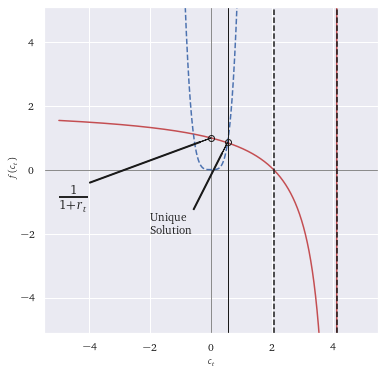

In [59]:
g = 4.12691520115423
gamma = 1.0
r = 0.01
x0 = 0.3195333487091828
nx = 10000
x = np.linspace(-5,5,nx)

ut.plot_settings()
fig, ax = plt.subplots(figsize = (6,6))

# AXES
ax.axhline(0, color='k', linewidth=.5)
ax.axvline(0, color='k', linewidth=.5)

# RHS & LHS
ax.plot(x, model.rhs(x, g, gamma, r), color = 'r')
ax.plot(x, model.lhs(x, x0), color = 'b')

# Solution point
cons = model.bisection(x0, g, gamma, r, 1e-4)
g_ = model.rhs(cons, g, gr)

# Key Sections
ax.axvline(g, linestyle='--', color='k')
ax.axvline(g/2, linestyle='--', color='k')
ax.axvline(cons, linewidth=1, color='k')

# Mark the Solution
circle_rad = 3  # This is the radius, in points
ax.plot(cons, g_, 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate('Unique\nSolution', xy=(cons, g_), xytext=(-2, -2),
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

# Mark the consumption = 0 point
circle_rad = 3  # This is the radius, in points
ax.plot(0, 1/(1+r), 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate(r'$\frac{1}{1+r_t}$', xy=(0, 1/(1+r)), xytext=(-5, -1), fontsize=20,
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

ax.set_ylim([-10,10])
ax.set_ylim([-5.1,5.1])
ax.set_xlabel(r'$c_t$')
ax.set_ylabel(r'$f(c_t)$')

plt.savefig('figures/test.pdf', format='pdf', bbox_inches = 'tight', transparent=True)

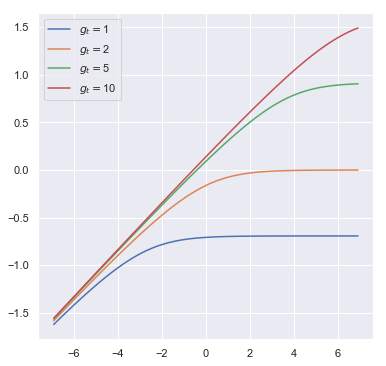

In [579]:
z = 1
#g = 5
gr = 1

fig, ax = plt.subplots(1,1,figsize = (6,6))

capital = np.logspace(-3,3,100)

for g in [1,2,5,10]:
    cons = []
    for k in capital:
        cons.append(bisection(z*np.sqrt(2*k),g,gr, 1e-4))
    ax.plot(np.log(capital), np.log(cons), label= r'$g_t = $' + str(g))
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.legend()
#plt.plot(capital, g-np.asarray(cons))
plt.savefig('/Users/fedemoro/Desktop/sols.eps', format='eps',bbox_inches = 'tight')#,transparent=True)